# Notebook 01: Sovereign Risk Dashboard (10YR vs. Gold)
#
# **Pair:** 10YR Treasury Futures (/ZB) vs. Gold Futures (/GC)
# **Thesis:** Tracking the breakdown of the classic "safe haven" correlation.
# In a classic risk-off, /ZB (price) and /GC rise together.
# In the new "Sovereign Risk / De-Dollarization" regime, /ZB falls (yields rise)
# while /GC rises, signaling a loss of faith in U.S. debt as a haven.
#
# **Proxies Used:**
# * `/ZB=F` (T-Note Future) -> `TLT` (20+ Yr Treasury ETF for clean price history)
# * `/GC=F` (Gold Future)   -> `GLD` (Gold ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `DFII10`: 10-Yr Real Yield (TIPS). The #1 driver. Gold (non-yielding) should move inversely to this.
# * `T10YIE`: 10-Yr Breakeven Inflation.
# * `DTWEXBGS`: Trade-Weighted U.S. Dollar Index.

In [94]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [95]:
# Cell 2: API & LLM Configuration (Refactored)
#
# Set up API keys, LLM endpoints, and asset tickers.
# ADDED: Volatility tickers GVZCLS and TYVIXCLS.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["GLD", "TLT"]
FRED_SERIES_IDS = [
    "DFII10", "T10YIE", "DTWEXBGS", # Core Macro Drivers
    "GVZCLS",                       # CBOE Gold Volatility Index
    "VIXCLS"                      # CBOE 10Y Treasury Volatility Index
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['GLD', 'TLT'] and ['DFII10', 'T10YIE', 'DTWEXBGS', 'GVZCLS', 'VIXCLS']


In [96]:
# Cell 3: Data Collection - yfinance
#
# (No change to this cell, using your provided version)
#
# Fetch historical price data for our ETF proxies (GLD, TLT).
# We only care about the 'Close' which accounts for dividends/splits.
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_772734/1623176768.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)
[*********************100%***********************]  2 of 2 completed


✅ Cell 3: yfinance data fetched successfully.
Ticker             GLD        TLT
Date                             
2025-10-27  367.010010  91.779999
2025-10-28  364.380005  92.019997
2025-10-29  363.000000  91.089996
2025-10-30  370.130005  90.559998
2025-10-31  368.119995  90.290001


In [97]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            DFII10  T10YIE  DTWEXBGS  GVZCLS  VIXCLS
2025-10-27    1.73    2.28       NaN   23.94   15.79
2025-10-28    1.71    2.28       NaN   24.03   16.42
2025-10-29    1.78    2.30       NaN   24.70   16.92
2025-10-30    1.82    2.29       NaN   24.82   16.91
2025-10-31     NaN    2.30       NaN   22.66   17.44


In [98]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill weekends/holidays.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (e.g., FRED data on non-market days, or vice-versa)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                   GLD        TLT  DFII10  T10YIE  DTWEXBGS  GVZCLS  VIXCLS
2025-10-27  367.010010  91.779999    1.73    2.28   121.342   23.94   15.79
2025-10-28  364.380005  92.019997    1.71    2.28   121.342   24.03   16.42
2025-10-29  363.000000  91.089996    1.78    2.30   121.342   24.70   16.92
2025-10-30  370.130005  90.559998    1.82    2.29   121.342   24.82   16.91
2025-10-31  368.119995  90.290001    1.82    2.30   121.342   22.66   17.44


In [99]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
# A Z-Score tells us how many standard deviations a value is from its mean.
# This is critical for comparing yields (e.g., 4.5) to prices (e.g., 200).

try:
    df_normalized = df.apply(zscore)
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                GLD           TLT        DFII10        T10YIE      DTWEXBGS        GVZCLS        VIXCLS
count  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03  1.303000e+03
mean  -3.053752e-16  1.745001e-16  8.725007e-17 -2.137627e-15 -1.570501e-15  5.998442e-16  6.107505e-16
std    1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00  1.000384e+00
min   -1.021445e+00 -1.408456e+00 -1.719004e+00 -3.808822e+00 -1.974946e+00 -2.309817e+00 -1.441412e+00
25%   -6.706025e-01 -7.776308e-01 -1.260863e+00 -4.305531e-01 -8.801266e-01 -5.801543e-01 -7.206495e-01
50%   -4.624164e-01 -4.597674e-01  5.027759e-01 -4.913557e-02  1.905595e-01 -1.096725e-01 -2.060892e-01
75%    4.035762e-01  1.068717e+00  8.352321e-01  3.867701e-01  6.374384e-01  5.147851e-01  5.307535e-01
max    3.848216e+00  2.220833e+00  1.289319e+00  3.710551e+00  2.191024e+00  5.409507e+00  6.214563e+00


In [100]:
# Cell 7: Feature Engineering - Ratios & Spreads (Refactored)
#
# (No functional change, but adding new metrics in subsequent cells)
#
# * Ratio: The price of GLD divided by the price of TLT. A rising ratio
#     means Gold is outperforming Treasuries (our thesis).
# * Spread (Normalized): The normalized Z-score of GLD minus the
#     normalized Z-score of TLT. This shows the *magnitude* of the divergence.

try:
    # 1. Price Ratio (The Core Signal)
    df['GLD_TLT_Ratio'] = df['GLD'] / df['TLT']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['GLD_TLT_Spread_Norm'] = df_normalized['GLD'] - df_normalized['TLT']
    
    # 3. Causal Spread (Gold vs. Real Yields)
    # This *should* be negative. If it turns positive, the relationship is broken.
    df['GLD_DFII10_Spread_Norm'] = df_normalized['GLD'] - df_normalized['DFII10']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['GLD_TLT_Ratio', 'GLD_TLT_Spread_Norm', 'GLD_DFII10_Spread_Norm']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            GLD_TLT_Ratio  GLD_TLT_Spread_Norm  GLD_DFII10_Spread_Norm
2025-10-27       3.998802             3.663282                2.500891
2025-10-28       3.959792             3.598649                2.466270
2025-10-29       3.985070             3.625426                2.382833
2025-10-30       4.087125             3.793713                2.488223
2025-10-31       4.077085             3.770377                2.449369


In [101]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# (No change to this cell, but HV calculation is added next)
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of GLD and TLT.
# This directly quantifies the "correlation breakdown" over time.

try:
    # First, get daily percentage returns
    df['GLD_pct'] = df['GLD'].pct_change()
    df['TLT_pct'] = df['TLT'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['GLD_pct'].rolling(window=30).corr(df['TLT_pct'])
    df['Corr_90D'] = df['GLD_pct'].rolling(window=90).corr(df['TLT_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27  0.005387  0.162123
2025-10-28 -0.000802  0.178168
2025-10-29  0.011054  0.183668
2025-10-30 -0.050887  0.167759
2025-10-31 -0.033744  0.154828


In [102]:
# Cell 8a: Feature Engineering - Historical Volatility (NEW)
#
# Calculate 30-day Historical (Realized) Volatility (HV) for our assets.
# This will be compared against Implied Volatility (IV).

try:
    # Calculate 30-day rolling HV (annualized)
    df['GLD_HV_30D'] = df['GLD_pct'].rolling(window=30).std() * np.sqrt(252)
    df['TLT_HV_30D'] = df['TLT_pct'].rolling(window=30).std() * np.sqrt(252)

    print("✅ Cell 8a: Historical Volatility (HV) calculated.")
    print(df[['GLD_HV_30D', 'TLT_HV_30D']].tail())

except Exception as e:
    print(f"❌ Cell 8a: HV calculation failed: {e}")

✅ Cell 8a: Historical Volatility (HV) calculated.
            GLD_HV_30D  TLT_HV_30D
2025-10-27    0.295113    0.083741
2025-10-28    0.296529    0.083827
2025-10-29    0.295567    0.089101
2025-10-30    0.298865    0.085227
2025-10-31    0.299138    0.085563


In [110]:
# Cell 8b: Feature Engineering - IV Rank (NEW)
#
# Calculate the 1-year (252-day) Implied Volatility Rank (IVR).
# This tells us if the current IV is "high" or "low" relative to its own history.
# IVR = 100 * (Current IV - 52wk Low) / (52wk High - 52wk Low)

try:
    # Calculate 252-day rolling min/max for Gold Vol
    df['GVZ_min_252D'] = df['GVZCLS'].rolling(window=252).min()
    df['GVZ_max_252D'] = df['GVZCLS'].rolling(window=252).max()
    
    # Calculate 252-day rolling min/max for Treasury Vol
    df['TYVIX_min_252D'] = df['VIXCLS'].rolling(window=252).min()
    df['TYVIX_max_252D'] = df['VIXCLS'].rolling(window=252).max()
    
    # Calculate IV Rank for both
    df['GVZ_IVR_252D'] = 100 * (df['GVZCLS'] - df['GVZ_min_252D']) / (df['GVZ_max_252D'] - df['GVZ_min_252D'])
    df['TYVIX_IVR_252D'] = 100 * (df['VIXCLS'] - df['TYVIX_min_252D']) / (df['TYVIX_max_252D'] - df['TYVIX_min_252D'])

    print("✅ Cell 8b: Implied Volatility Rank (IVR) calculated.")
    print(df[['GVZCLS', 'GVZ_IVR_252D', 'VIXCLS', 'TYVIX_IVR_252D']].tail())

except Exception as e:
    print(f"❌ Cell 8b: IV Rank calculation failed: {e}")

✅ Cell 8b: Implied Volatility Rank (IVR) calculated.
            GVZCLS  GVZ_IVR_252D  VIXCLS  TYVIX_IVR_252D
2025-10-27   23.94     51.667578   15.79        7.633974
2025-10-28   24.03     52.159650   16.42        9.226491
2025-10-29   24.70     55.822854   16.92       10.490394
2025-10-30   24.82     56.478950   16.91       10.465116
2025-10-31   22.66     44.669218   17.44       11.804853


In [111]:
# Cell 8c: Feature Engineering - VRP & Signal Velocity (NEW)
#
# Calculate the Volatility Risk Premium (VRP) and Signal Velocity.
# VRP = Implied Vol (IV) - Historical Vol (HV).
#     Positive VRP = Options are "expensive" (Good for selling premium).
#     Negative VRP = Options are "cheap" (Good for buying vega).
#
# Signal Velocity = 5-day change in the normalized spread.
#     This shows if the thematic signal is accelerating.

try:
    # 1. Volatility Risk Premium (VRP)
    df['GLD_VRP'] = df['GVZCLS'] - df['GLD_HV_30D']
    df['TLT_VRP'] = df['VIXCLS'] - df['TLT_HV_30D']
    
    # 2. Signal Velocity
    df['Signal_Velocity_5D'] = df['GLD_TLT_Spread_Norm'].diff(5)

    print("✅ Cell 8c: VRP and Signal Velocity calculated.")
    print(df[['GLD_VRP', 'TLT_VRP', 'Signal_Velocity_5D']].tail())
    
    # Drop NaNs created by all the new rolling windows to clean the final df
    df = df.dropna()

except Exception as e:
    print(f"❌ Cell 8c: VRP/Velocity calculation failed: {e}")

✅ Cell 8c: VRP and Signal Velocity calculated.
              GLD_VRP    TLT_VRP  Signal_Velocity_5D
2025-10-27  23.644887  15.706259           -0.711812
2025-10-28  23.733471  16.336173           -0.249735
2025-10-29  24.404433  16.830899           -0.220283
2025-10-30  24.521135  16.824773           -0.117395
2025-10-31  22.360862  17.354437           -0.113882


Plotting Cell 9: Core Thesis...


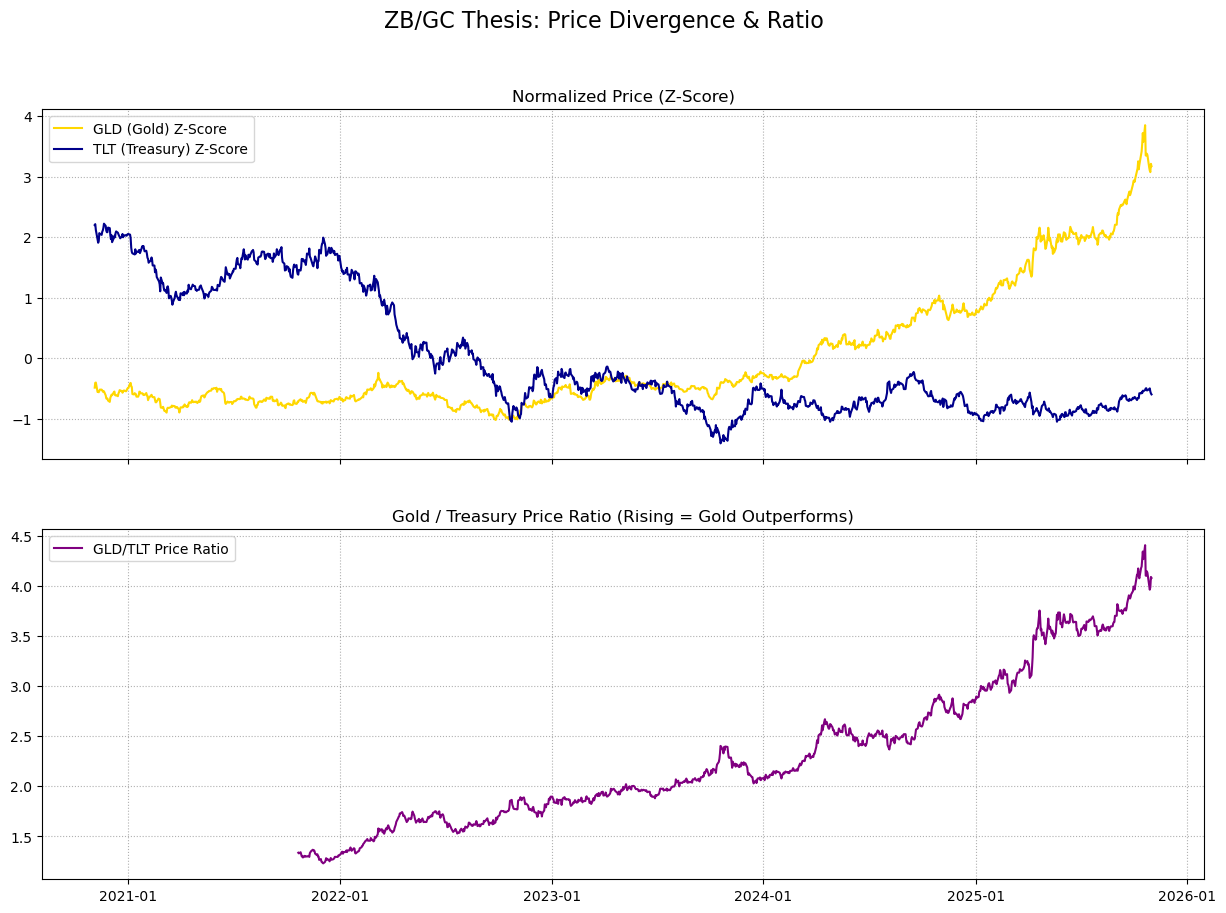

In [112]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of GLD vs. TLT.
# Plot 2: The GLD/TLT Ratio.
#
# This chart shows *what* is happening. Are they diverging? Is the ratio
# in a clear uptrend?

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('ZB/GC Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['TLT'], label='TLT (Treasury) Z-Score', color='darkblue')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['GLD_TLT_Ratio'], label='GLD/TLT Price Ratio', color='purple')
    ax2.set_title('Gold / Treasury Price Ratio (Rising = Gold Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Driver...


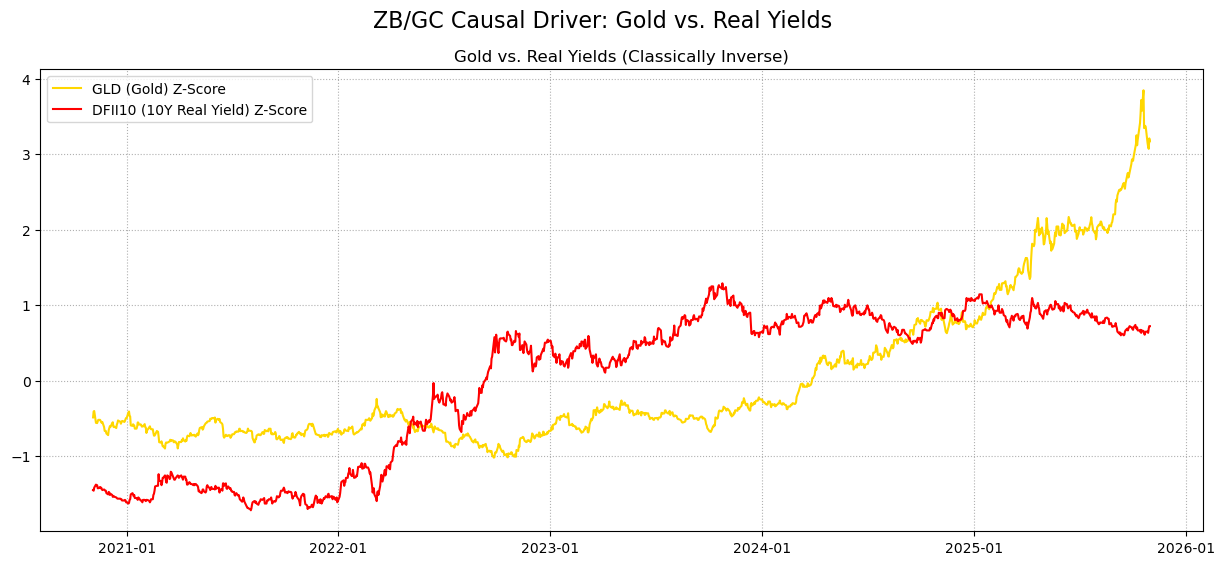

In [113]:
# Cell 10: Visualization - Causal Driver (Real Yields)
#
# Plot 1: Normalized prices of GLD vs. 10Y Real Yield (DFII10).
#
# This chart shows *why* it's happening.
# Classic relationship: INVERSE. GLD (gold) rises, DFII10 (real yield) falls.
# If they both rise together, the "safe haven" model is broken.

try:
    print("Plotting Cell 10: Causal Driver...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC Causal Driver: Gold vs. Real Yields', fontsize=16)

    ax1.plot(df_normalized.index, df_normalized['GLD'], label='GLD (Gold) Z-Score', color='gold')
    ax1.plot(df_normalized.index, df_normalized['DFII10'], label='DFII10 (10Y Real Yield) Z-Score', color='red')
    ax1.set_title('Gold vs. Real Yields (Classically Inverse)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


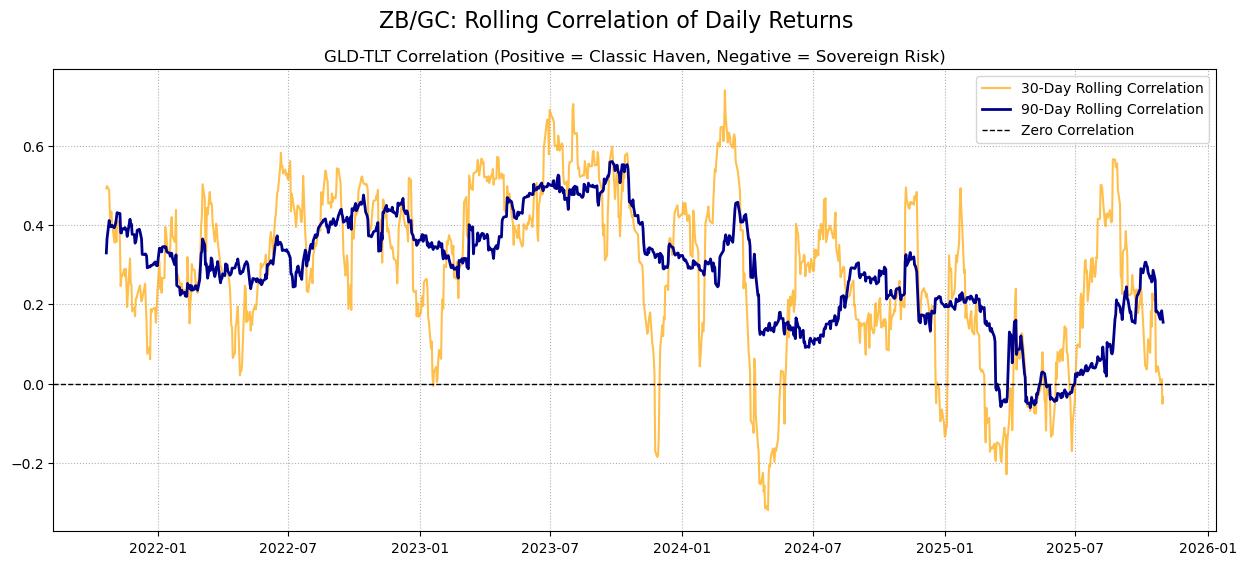

In [114]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the thesis. A positive correlation (e.g., +0.5)
# means they act as classic risk-off partners. A negative correlation
# (e.g., -0.3) means the "Sovereign Risk" thesis is in play.

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('ZB/GC: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0, color='black', linestyle='--', linewidth=1, label='Zero Correlation')
    ax1.set_title('GLD-TLT Correlation (Positive = Classic Haven, Negative = Sovereign Risk)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

Plotting Cell 11a: Volatility Dashboard...


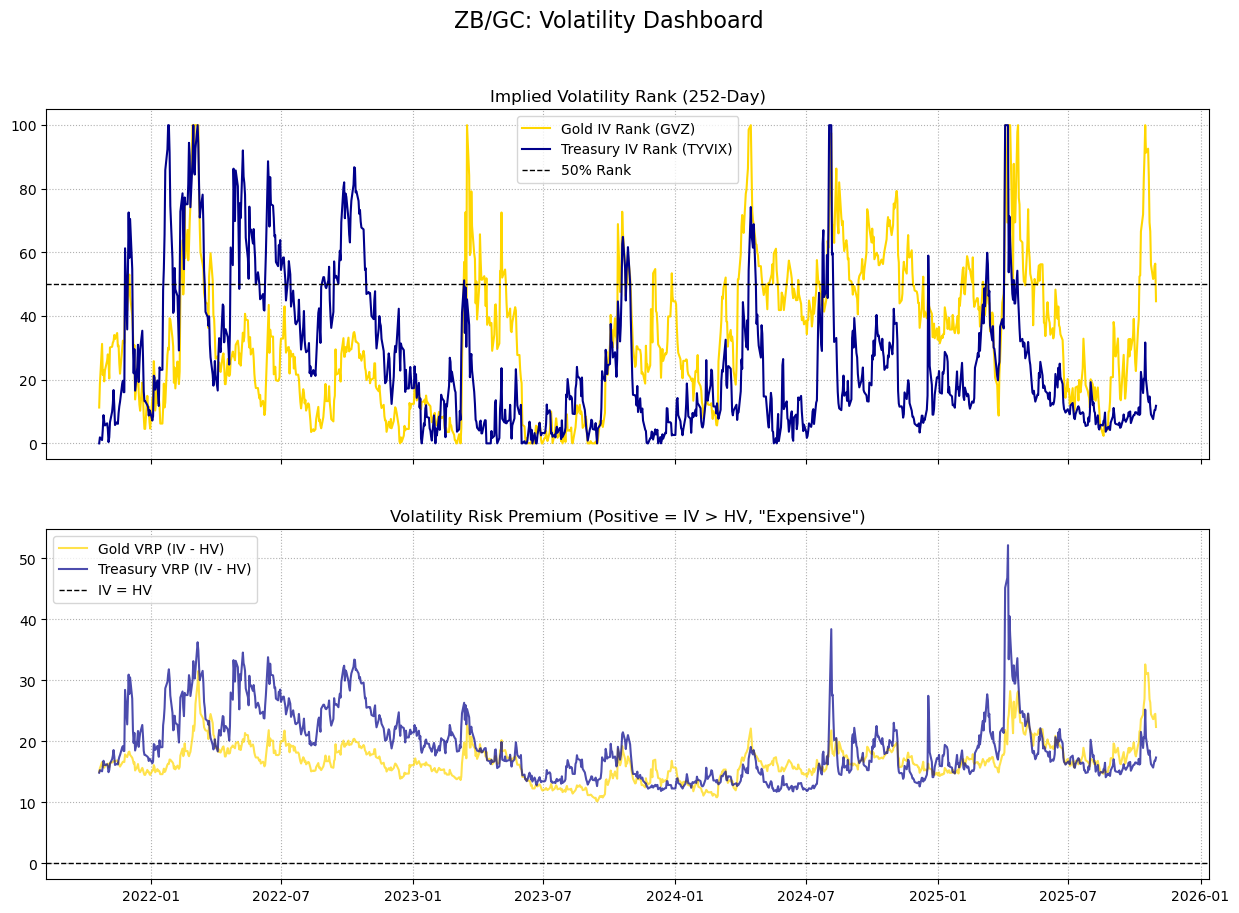

In [115]:
# Cell 11a: Visualization - Volatility Dashboard (NEW)
#
# Plot the IV Rank and the Volatility Risk Premium (VRP).
# This chart tells us *when* to put on a trade and *what kind*.

try:
    print("Plotting Cell 11a: Volatility Dashboard...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('ZB/GC: Volatility Dashboard', fontsize=16)

    # Plot 1: IV Rank (Tells you if vol is "high" or "low")
    ax1.plot(df.index, df['GVZ_IVR_252D'], label='Gold IV Rank (GVZ)', color='gold')
    ax1.plot(df.index, df['TYVIX_IVR_252D'], label='Treasury IV Rank (TYVIX)', color='darkblue')
    ax1.axhline(50, color='black', linestyle='--', linewidth=1, label='50% Rank')
    ax1.set_title('Implied Volatility Rank (252-Day)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Volatility Risk Premium (IV vs HV)
    ax2.plot(df.index, df['GLD_VRP'], label='Gold VRP (IV - HV)', color='gold', alpha=0.7)
    ax2.plot(df.index, df['TLT_VRP'], label='Treasury VRP (IV - HV)', color='darkblue', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='IV = HV')
    ax2.set_title('Volatility Risk Premium (Positive = IV > HV, "Expensive")')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11a: Volatility plotting failed: {e}")

In [116]:
# Cell 12: LLM Strategy Router (Refactored)
#
# Pass all macro AND volatility data to the LLM for a routed strategy.

try:
    print("Sending data to LLM for strategy routing...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # --- Create Data Summary ---
    
    # 1. Macro Theme Summary
    macro_summary = f"""
--- MACRO THEME (Pair: ZB/GC) ---
- **Thematic Bias:** Sovereign Risk (GLD outperforming TLT)
- **Signal Strength (Z-Score):** {latest_data['GLD_TLT_Spread_Norm']:.2f}
- **Signal Velocity (5D Change):** {latest_data['Signal_Velocity_5D']:.2f}
- **Regime Type (90D Corr):** {latest_data['Corr_90D']:.3f} (Low/Negative = Trend, High = Range)
"""
    
    # 2. Volatility Dashboard Summary
    # We will focus on the asset with the strongest thematic bias.
    # If the Z-score is positive, the bias is Long GLD. If negative, Long TLT.
    
    target_asset = 'GLD' if latest_data['GLD_TLT_Spread_Norm'] > 0 else 'TLT'
    
    if target_asset == 'GLD':
        vol_summary = f"""
--- VOLATILITY DASHBOARD (Asset: GLD) ---
- **Implied Vol (GVZCLS):** {latest_data['GVZCLS']:.2f}
- **IV Rank (1-Year):** {latest_data['GVZ_IVR_252D']:.1f}%
- **Vol Risk Premium (IV vs HV):** {latest_data['GLD_VRP']:.2f} (Positive = "Expensive", Negative = "Cheap")
"""
        vol_regime_prompt = f"Volatility is {'High/Expensive' if latest_data['GVZ_IVR_252D'] > 50 else 'Low/Cheap'}."
    else: # Target is TLT
        vol_summary = f"""
--- VOLATILITY DASHBOARD (Asset: TLT) ---
- **Implied Vol (TYVIXCLS):** {latest_data['TYVIXCLS']:.2f}
- **IV Rank (1-Year):** {latest_data['TYVIX_IVR_252D']:.1f}%
- **Vol Risk Premium (IV vs HV):** {latest_data['TLT_VRP']:.2f} (Positive = "Expensive", Negative = "Cheap")
"""
        vol_regime_prompt = f"Volatility is {'High/Expensive' if latest_data['TYVIX_IVR_252D'] > 50 else 'Low/Cheap'}."

    # --- Create the LLM Prompt ---
    prompt = f"""
**Role:** You are an Intelligence Desk Analyst routing a macro theme to a specific options strategy.

**Your Available Strategies:**
* **IV Calm / Range:** Bull Put, Bear Call, Iron Condor (Sell Premium)
* **IV Expanding / Breakout:** Calendar, Diagonal, Double Diagonal (Buy Vega)

**Latest OSINT Data:**
{macro_summary}
{vol_summary}

**Your Task (Provide a 3-part recommendation):**
1.  **Volatility Regime:** Based on IV Rank and VRP, is volatility "High/Expensive" or "Low/Cheap"? Does this favor selling premium or buying vega?
2.  **Thematic Regime:** Based on Signal Strength, Velocity, and Correlation, is the macro theme a "Strong Trend," a "Weak Trend," or a "Range/Chop"?
3.  **Strategy Route:** Combine these two analyses to select the *optimal* strategy from the list.
    
    **Routing Logic:**
    * **High IVR (>50) + Strong Trend:** Use a directionally-biased *credit spread* (e.g., Bull Put, Bear Call).
    * **High IVR (>50) + Range/Chop:** Use a *neutral* credit strategy (e.g., Iron Condor).
    * **Low IVR (<50) + Strong Trend:** Use a directionally-biased *debit/vega* strategy (e.g., Diagonal).
    * **Low IVR (<50) + Range/Chop:** Use a *neutral* vega strategy (e.g., Calendar) or No Trade.

    What is your final, routed strategy recommendation for the **{target_asset}** asset and the clear logic?
    """
    
    # Get LLM response
    llm_response = ask_llm(prompt)
    
    print("\n--- 🤖 LLM STRATEGY ROUTER ---")
    print(llm_response)
    print("---------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Strategy Router failed: {e}")

Sending data to LLM for strategy routing...



--- 🤖 LLM STRATEGY ROUTER ---
### 1. Volatility Regime:
- **Implied Volatility Rank (IVR):** The IV Rank of GLD at 44.7% suggests that implied volatility is currently in the middle range, not particularly high or low.
- **Vol Risk Premium (VRP):** A VRP of 22.36 indicates that implied volatility is slightly "expensive" compared to historical levels.

Given these factors:
- The IV Rank is below 50, indicating "Low/Cheap" volatility.
- However, the positive VRP suggests a slight premium in implied volatility relative to historical norms.

**Recommendation:** This favors selling premium strategies as they are currently more attractive due to the relatively low and cheap implied volatility environment.

### 2. Thematic Regime:
- **Signal Strength (Z-Score):** The Z-Score of 3.77 indicates a strong thematic bias.
- **Signal Velocity (5D Change):** A negative change of -0.11 suggests that the strength is weakening slightly, but it remains significant.
- **Regime Type (90D Corr):** With a co